3


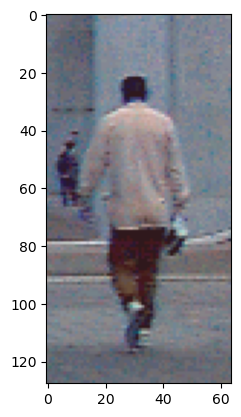

In [6]:
import cv2
import matplotlib.pyplot as plt
import scipy
import numpy as np

img = cv2.imread('train/pos/per00002.ppm')
plt.imshow(img)

def gradients(img):

    print(len(img.shape))
    views = None
    if len(img.shape) == 3:
        views = 3
    else:
        views = 1
    for view in range(views):
        im = img
        if views > 1:
            im = img[:, :, view]

        dx = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 1)
        dy = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 0)
        A = np.sqrt(dx**2 + dy**2)
